In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import secondary_fyncions as sf

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, accuracy_score

from nltk.stem.snowball import PorterStemmer
from nltk.corpus import stopwords

In [18]:
# import nltk
# nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/tay/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
data = pd.read_csv('IMDB Dataset.csv')
data['sentiment'] = data['sentiment'].map({'positive':1, 'negative':0})

In [8]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


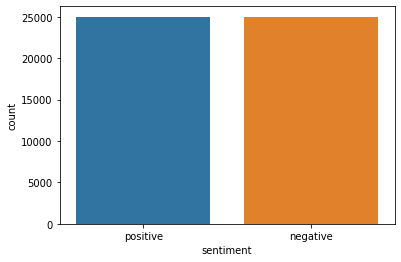

In [5]:
sns.countplot(x=data['sentiment'])

# Подготовим данные

In [19]:
stop = stopwords.words('english')
stemmer = nltk.stem.snowball.EnglishStemmer('english')

def data_Stemmer(text):
    return ' '.join([stemmer.stem(word) for word in text.split(' ') if word not in stop])

In [22]:
data['review'] = data['review'].apply(lambda x: data_Stemmer(x))

In [25]:
tf_vector = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), min_df=0.001, max_df=0.5)

In [30]:
X_train, X_test, y_train, y_test  = train_test_split(data['review'], data['sentiment'], test_size=0.30, random_state=42)
X_train_tfidf = tf_vector.fit_transform(X_train)
X_test_tfidf = tf_vector.transform(X_test)

# Построим модел SGDClassifier

In [35]:
logit_sgd = SGDClassifier(
    loss='log', 
    shuffle=True, 
    n_iter_no_change=10, 
    max_iter=1000, 
    penalty='l1', 
    random_state=42
)

## Качество модели

In [41]:
logit_sgd.fit(X_train_tfidf, y_train)

print("На обучающей выборке", accuracy_score(logit_sgd.predict(X_train_tfidf), y_train))

print("На тестовой выборке", accuracy_score(logit_sgd.predict(X_test_tfidf), y_test))

print(classification_report(logit_sgd.predict(X_test_tfidf), y_test))

На обучающей выборке 0.8562857142857143
На тестовой выборке 0.8544666666666667
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      7036
           1       0.88      0.84      0.86      7964

    accuracy                           0.85     15000
   macro avg       0.85      0.86      0.85     15000
weighted avg       0.86      0.85      0.85     15000



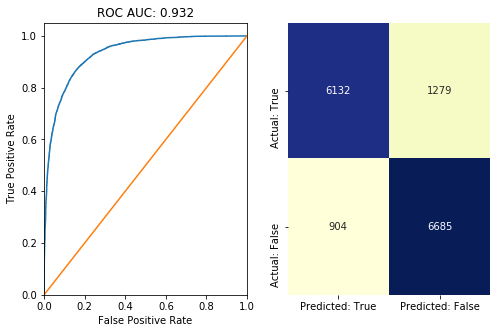

In [122]:
plt.figure(figsize=(8, 5))

plt.subplot(1,2,1)

sf.plot_roc_curve(
    logit_sgd.predict_proba(X_test_tfidf)[:,1],
    y_test
)
plt.subplot(1,2,2)
sf.plot_confusion(y_test,logit_sgd.predict(X_test_tfidf))

# Визуализация коэффициентов

In [100]:
def visualize_coefficients(coef, feature_names, n_top_features=25):
    sort_coef = np.argsort(coef)
    interesting_coefficients = sort_coef[-n_top_features:]
    
    plt.figure(figsize=(15, 25))
    plt.subplot(510+0+1)
    colors = ["lightblue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + n_top_features), 
               feature_names[interesting_coefficients], rotation=60, ha="right", fontsize=14);
    plt.title('positive')
    
    interesting_coefficients = np.flip(sort_coef[:n_top_features])
    plt.subplot(510+1+1)
    colors = ["lightblue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + n_top_features), 
               feature_names[interesting_coefficients], rotation=60, ha="right", fontsize=14);
    plt.title('negative')
    
    plt.tight_layout()
    

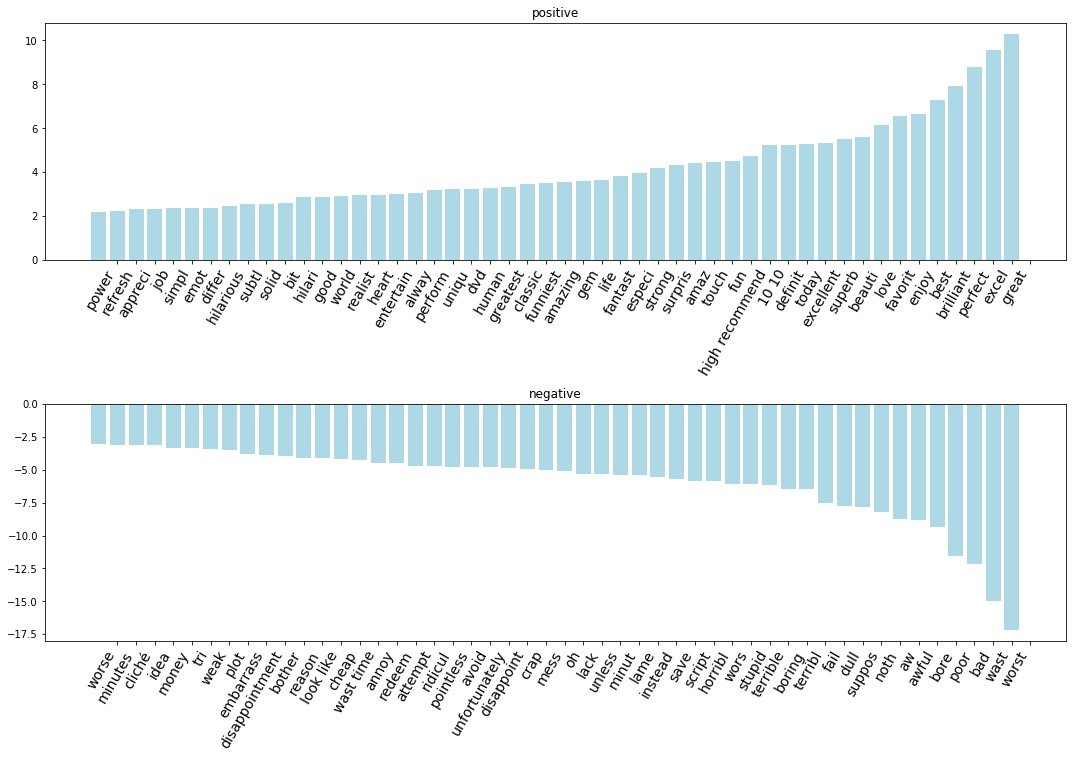

In [101]:
visualize_coefficients(logit_sgd.coef_[0,:], tf_vector.get_feature_names(),
                        n_top_features=50)